# Introduction

Refer to this [article](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/) .

# Steps

##  Step 1. Get Timeseries Data

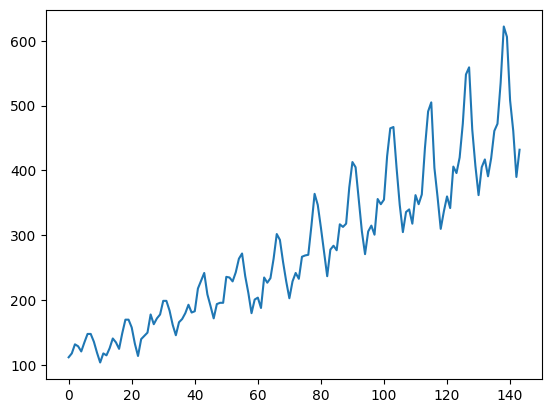

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('./data/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

## Step 2. train-test split

In [2]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

## Step 3. Generate Dataset

In [3]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        
    return torch.tensor(X), torch.tensor(y)

In [4]:
lookback = 4

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

# tensor dimensions (window sample, time steps, features)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([86, 10, 1]) torch.Size([86, 10, 1])
torch.Size([38, 10, 1]) torch.Size([38, 10, 1])


/var/folders/s7/4mzvpqd570j7jzsl_gsb_rnc0000gn/T/ipykernel_48171/1481734521.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.tensor(X), torch.tensor(y)


## Step 4. Define Model

In [5]:

import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## Step 5. Training

In [6]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 4000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 500 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 222.7258, test RMSE 419.0395
Epoch 500: train RMSE 65.8185, test RMSE 236.3139
Epoch 1000: train RMSE 23.3986, test RMSE 131.7807
Epoch 1500: train RMSE 16.1466, test RMSE 87.4785
Epoch 2000: train RMSE 13.7086, test RMSE 76.9690
Epoch 2500: train RMSE 12.3997, test RMSE 74.9936
Epoch 3000: train RMSE 11.9699, test RMSE 76.0138
Epoch 3500: train RMSE 11.8352, test RMSE 76.0818


## Step 6. Prediction

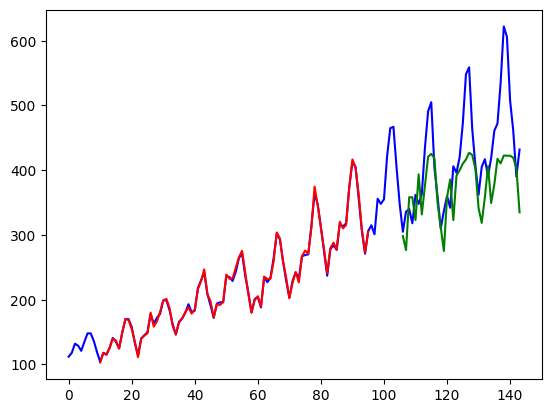

In [7]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()